# Лекция 1: Въведение в AI и машинно самообучение за NLP

**Продължителност:** 2-2.5 часа  
**Предпоставки:** Основи на Python, линейна алгебра, вероятности  
**Следваща лекция:** Невронни мрежи за NLP

---
## Цели на лекцията

След тази лекция ще можете:

- Формулирате NLP задача като ML проблем (вход, изход, хипотеза)
- Разбирате трите парадигми на обучение и техните NLP приложения
- Идентифицирате пренагаждане и ъндърфитване в текстови модели
- Оценявате модели с подходящи метрики (accuracy, precision, recall, F1)
- **Изграждате n-gram езиков модел и изчислявате perplexity**

### Пътна карта

```
1. Мотивация → 2. Формулиране → 3. Терминология → 4. Парадигми
    ↓
5. Генерализация → 6. Метрики → 7. N-gram модели → 8. NLP предизвикателства
    ↓
9. Практически workflow → 10. Обобщение
```

In [1]:
# Импортиране на библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re

# Scikit-learn
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Настройки
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

print("Библиотеките са заредени успешно.")

Библиотеките са заредени успешно.


---
## 1. Мотивация: AI и ML за език

### Какво е AI, ML и NLP?

| Термин | Определение |
|--------|-------------|
| **AI** (Artificial Intelligence) | Широка област за създаване на интелигентни системи |
| **ML** (Machine Learning) | Подход, при който системите се учат от данни |
| **NLP** (Natural Language Processing) | Приложение на ML за разбиране и генериране на език |

### Защо езикът е труден за компютрите?

**Двусмисленост (Ambiguity)**
- "Видях човек с телескоп" — Кой има телескопа?
- "Банката е затворена" — Финансова институция или речен бряг?

**Контекст и сарказъм**
- "Страхотно!" — Положително или саркастично?

**Вариативност**
- "Филмът ми хареса" ≈ "Страхотен филм" ≈ "10/10"

In [2]:
# Примери за двусмисленост в sentiment analysis
examples = [
    ("Този филм е невероятен!", "положително"),
    ("Невероятно, че пуснаха такъв филм.", "отрицателно"),
    ("Актьорите играят добре.", "положително"),
    ("Е, добре де... поне свърши.", "отрицателно"),
]

print("Примери за двусмисленост:\n")
for text, sentiment in examples:
    marker = "+" if sentiment == "положително" else "-"
    print(f"[{marker}] {text}")

Примери за двусмисленост:

[+] Този филм е невероятен!
[-] Невероятно, че пуснаха такъв филм.
[+] Актьорите играят добре.
[-] Е, добре де... поне свърши.


Думи като "невероятен" и "добре" могат да носят различно значение в зависимост от контекста.

### Успехи на NLP днес

| Приложение | Примери |
|------------|--------|
| Машинен превод | Google Translate, DeepL |
| Разговорни асистенти | ChatGPT, Claude, Gemini |
| Sentiment analysis | Анализ на клиентски отзиви |
| Summarization | Автоматични резюмета на документи |

---
## 2. Формулиране на ML проблем

### Какво означава "машина се учи"?

**Дефиниция (Tom Mitchell, 1997):**

> Компютърна програма се учи от опит **E** по отношение на задача **T** и метрика **P**, ако производителността по **T**, измерена с **P**, се подобрява с **E**.

**Пример: Spam филтър**

- **T (Task):** Класифицирай имейл като spam или не-spam
- **E (Experience):** База от етикетирани имейли
- **P (Performance):** Процент правилно класифицирани

### Формална нотация

| Символ | Значение | NLP пример |
|--------|----------|------------|
| $\mathcal{X}$ | Входно пространство | Текстове, изречения |
| $\mathcal{Y}$ | Изходно пространство | Етикети, категории |
| $(x^{(i)}, y^{(i)})$ | Тренировъчен пример | ("Great movie!", positive) |
| $h: \mathcal{X} \to \mathcal{Y}$ | Хипотеза (модел) | Класификатор |

**Цел:** Намери $h$, което добре предсказва $y$ за нови $x$.

In [3]:
# Конкретен пример: Spam класификация
spam_data = [
    ("Честито! Спечелихте $1,000,000!", "spam"),
    ("Здравей, утре ще се видим за кафе?", "not spam"),
    ("БЕЗПЛАТНО!!! Изтеглете сега!!!", "spam"),
    ("Изпращам ти файловете от срещата.", "not spam"),
    ("Купи Виагра на ниски цени!", "spam"),
    ("Потвърждавам участие в конференцията.", "not spam"),
]

print("Тренировъчни данни за spam класификация:\n")
print(f"{'Текст':<45} {'Етикет':>10}")
print("=" * 57)
for text, label in spam_data:
    short = text[:42] + "..." if len(text) > 45 else text
    print(f"{short:<45} {label:>10}")

Тренировъчни данни за spam класификация:

Текст                                             Етикет
Честито! Спечелихте $1,000,000!                     spam
Здравей, утре ще се видим за кафе?              not spam
БЕЗПЛАТНО!!! Изтеглете сега!!!                      spam
Изпращам ти файловете от срещата.               not spam
Купи Виагра на ниски цени!                          spam
Потвърждавам участие в конференцията.           not spam


Това са примери за $X$ (входове) и $Y$ (етикети). Моделът трябва да научи връзката между тях.

---
## 3. Основна ML терминология

### Признаци (Features) в NLP

Компютрите работят с числа. Трябва да превърнем текста в числов вектор.

| Метод | Описание |
|-------|----------|
| **Bag-of-Words** | Брои появявания на думи |
| **TF-IDF** | Претеглено броене (рядките думи тежат повече) |
| **N-грами** | Поредици от N думи |
| **Embeddings** | Плътни вектори (Лекция 2) |

In [4]:
# Bag-of-Words демонстрация
texts = [
    "Обичам този филм",
    "Мразя този филм",
    "Филмът е страхотен"
]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

bow_df = pd.DataFrame(
    X.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=texts
)

print("Bag-of-Words представяне:\n")
print(bow_df.to_string())

Bag-of-Words представяне:

                    мразя  обичам  страхотен  този  филм  филмът
Обичам този филм        0       1          0     1     1       0
Мразя този филм         1       0          0     1     1       0
Филмът е страхотен      0       0          1     0     0       1


Всяка колона е признак (feature), всеки ред е документ. Забележете: губим информация за реда на думите.

In [5]:
# Проблем с BoW: губим реда
s1 = "кучето гони котката"
s2 = "котката гони кучето"

vec = CountVectorizer()
X = vec.fit_transform([s1, s2])

print(f"'{s1}'")
print(f"'{s2}'")
print(f"\nВектори еднакви: {np.array_equal(X[0].toarray(), X[1].toarray())}")

'кучето гони котката'
'котката гони кучето'

Вектори еднакви: True


Различно значение, но идентично BoW представяне. Това е фундаментално ограничение.

### Етикети (Labels) в NLP

| Задача | Етикети | Пример |
|--------|---------|--------|
| Sentiment | {positive, negative, neutral} | "Страхотен филм!" → positive |
| Spam | {spam, not spam} | "БЕЗПЛАТНО!!!" → spam |
| Topic | {sports, politics, tech, ...} | "Левски победи" → sports |
| NER | {B-PER, I-PER, B-ORG, O, ...} | "Иван" → B-PER |

### Разделяне на данните

Искаме да оценим как моделът работи на **нови** данни.

| Набор | Цел | Размер |
|-------|-----|--------|
| **Train** | Обучение | 60-80% |
| **Validation** | Настройка на хиперпараметри | 10-20% |
| **Test** | Финална оценка | 10-20% |

**Златно правило:** Никога не тренирайте на тестови данни!

In [6]:
# Зареждане на 20 Newsgroups dataset
categories = ['rec.sport.baseball', 'sci.space', 'comp.graphics', 'talk.politics.misc']

newsgroups = fetch_20newsgroups(
    subset='all',
    categories=categories,
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)

texts = newsgroups.data
labels = newsgroups.target
label_names = newsgroups.target_names

print(f"Документи: {len(texts)}")
print(f"Категории: {len(label_names)}")
for i, name in enumerate(label_names):
    print(f"  {i}: {name} ({sum(labels == i)} док.)")

Документи: 3729
Категории: 4
  0: comp.graphics (973 док.)
  1: rec.sport.baseball (994 док.)
  2: sci.space (987 док.)
  3: talk.politics.misc (775 док.)


In [7]:
# Разделяне: train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} ({len(X_train)/len(texts)*100:.0f}%)")
print(f"Val:   {len(X_val)} ({len(X_val)/len(texts)*100:.0f}%)")
print(f"Test:  {len(X_test)} ({len(X_test)/len(texts)*100:.0f}%)")

Train: 2610 (70%)
Val:   559 (15%)
Test:  560 (15%)


---
## 4. Парадигми на машинно самообучение

| Парадигма | Данни | Цел | NLP примери |
|-----------|-------|-----|-------------|
| **С учител** | X + Y | Предсказване на Y | Класификация, NER, превод |
| **Без учител** | Само X | Откриване на структура | Topic modeling, clustering |
| **С подсилване** | Състояния + награди | Максимизиране на награда | RLHF |

### Обучение с учител (Supervised Learning)

**Имаме:** Примери с етикети $(x^{(i)}, y^{(i)})$  
**Искаме:** Модел $h(x)$, който предсказва $y$ за нови $x$

**Типове задачи:**
- Text classification (sentiment, spam, topic)
- Sequence labeling (NER, POS tagging)
- Seq2seq (превод, summarization)

In [8]:
# Обучение на текстов класификатор
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

print(f"Размерност: {X_train_vec.shape}")

Размерност: (2610, 5000)


In [9]:
# Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_vec, y_train)

train_acc = accuracy_score(y_train, model.predict(X_train_vec))
val_acc = accuracy_score(y_val, model.predict(X_val_vec))

print(f"Train accuracy: {train_acc:.3f}")
print(f"Val accuracy:   {val_acc:.3f}")

Train accuracy: 0.962
Val accuracy:   0.873


In [10]:
# Примерни предсказания
y_val_pred = model.predict(X_val_vec)

print("Примерни предсказания:\n")
for i in range(3):
    text = X_val[i][:80] + "..." if len(X_val[i]) > 80 else X_val[i]
    true_l = label_names[y_val[i]].split('.')[-1]
    pred_l = label_names[y_val_pred[i]].split('.')[-1]
    mark = "OK" if y_val[i] == y_val_pred[i] else "X"
    print(f"[{mark}] {text}")
    print(f"    True: {true_l}, Pred: {pred_l}\n")

Примерни предсказания:

[OK] 
And who's advocating that?  Hate crimes laws are aimed at the motivations
of th...
    True: misc, Pred: misc

[OK] 
BULLSHIT. How many lakes have ceased to be able to support life from
purely nat...
    True: misc, Pred: misc

[OK] With the continuin talk about the "End of the Space Age" and complaints 
by gove...
    True: space, Pred: space



### Обучение без учител (Unsupervised Learning)

**Имаме:** Само данни $x^{(i)}$ (без етикети)  
**Искаме:** Открием скрита структура

**NLP приложения:**
- Topic modeling (LDA)
- Clustering на документи
- Word embeddings (Word2Vec)
- **Language modeling** — основа на LLM!

### Обучение с подсилване (Reinforcement Learning)

**Имаме:** Агент, действия, награди  
**Искаме:** Стратегия за максимизиране на награда

**В NLP: RLHF (Reinforcement Learning from Human Feedback)**
- Използва се за alignment на LLM (ChatGPT, Claude)
- Човек оценява отговорите
- Моделът се обучава да генерира по-добре оценени отговори

Ще видим RLHF в детайли в Лекция 8.

---
## 5. Генерализация: Пренагаждане и ъндърфитване

### Централният проблем в ML

**Цел:** Модел, който работи добре на **нови** данни.

| Проблем | Описание | Симптом |
|---------|----------|--------|
| **Ъндърфитване** | Модел твърде прост | Лоша точност навсякъде |
| **Пренагаждане** | Модел запомня данните | Висока train, ниска test |

### Пренагаждане в текстови модели

Модел "запомня" текст когато:
- Научава специфични фрази от train данните
- Не разпознава перифразирания
- Чувствителен към конкретен речник

**Пример:**
- Train: "Страхотен филм, препоръчвам!" → positive
- Test: "Невероятен филм, гледайте го!" → ??? (нови думи)

In [11]:
# Демонстрация на пренагаждане
n_samples = 500
X_train_small = X_train[:n_samples]
y_train_small = y_train[:n_samples]

vocab_sizes = [100, 500, 1000, 2000, 5000, 10000]
train_scores = []
val_scores = []

for vocab_size in vocab_sizes:
    vec = TfidfVectorizer(max_features=vocab_size, stop_words='english')
    X_tr = vec.fit_transform(X_train_small)
    X_v = vec.transform(X_val)
    
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_tr, y_train_small)
    
    train_scores.append(accuracy_score(y_train_small, clf.predict(X_tr)))
    val_scores.append(accuracy_score(y_val, clf.predict(X_v)))

print(f"{'Vocab':<8} {'Train':<8} {'Val':<8}")
print("=" * 24)
for v, tr, va in zip(vocab_sizes, train_scores, val_scores):
    print(f"{v:<8} {tr:.3f}    {va:.3f}")

Vocab    Train    Val     
100      0.732    0.590
500      0.932    0.733
1000     0.954    0.787
2000     0.968    0.798
5000     0.970    0.814
10000    0.972    0.818


С увеличаване на vocab_size, train accuracy расте, но val accuracy спира да се подобрява.

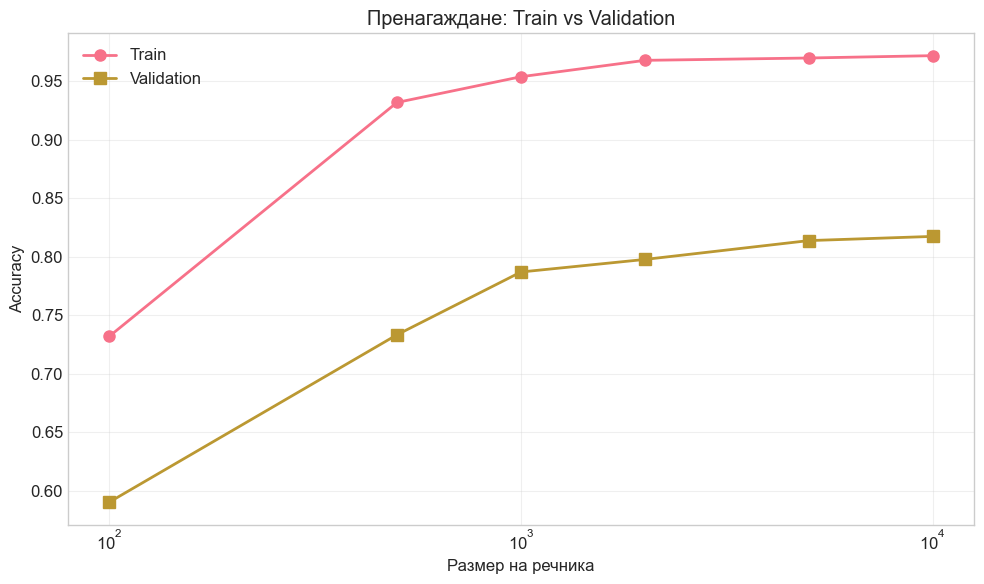

In [12]:
# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(vocab_sizes, train_scores, 'o-', label='Train', linewidth=2, markersize=8)
plt.plot(vocab_sizes, val_scores, 's-', label='Validation', linewidth=2, markersize=8)

plt.xlabel('Размер на речника')
plt.ylabel('Accuracy')
plt.title('Пренагаждане: Train vs Validation')
plt.legend()
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Голяма разлика между train и val = пренагаждане.

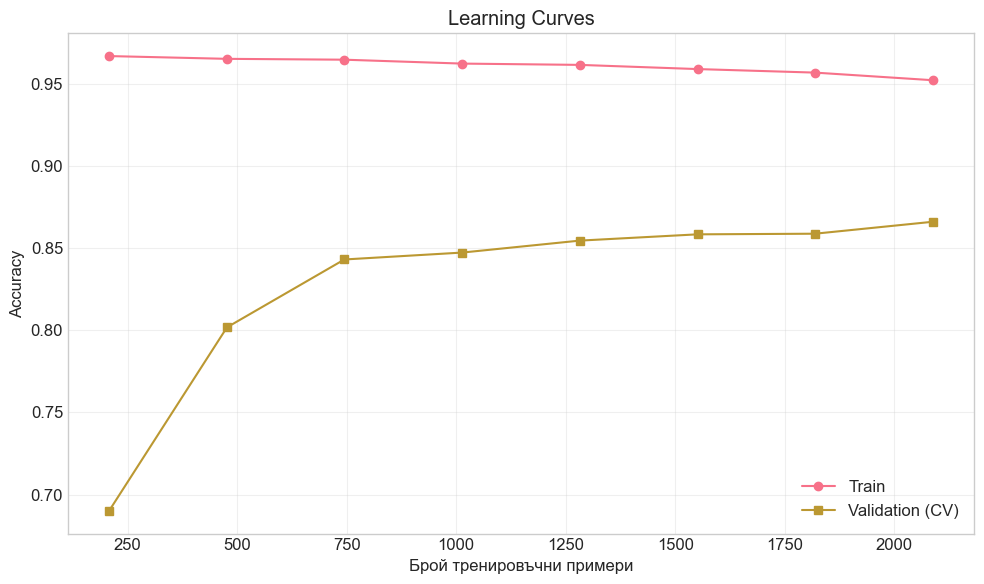

In [13]:
# Learning curves
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X_all_vec = vectorizer.fit_transform(X_train)

train_sizes, train_scores_lc, val_scores_lc = learning_curve(
    LogisticRegression(max_iter=1000, random_state=42),
    X_all_vec, y_train,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5, scoring='accuracy', n_jobs=-1
)

train_mean = train_scores_lc.mean(axis=1)
val_mean = val_scores_lc.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Train')
plt.plot(train_sizes, val_mean, 's-', label='Validation (CV)')
plt.xlabel('Брой тренировъчни примери')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

С повече данни кривите се сближават — по-малко пренагаждане.

### Bias-Variance Tradeoff

$$\text{Error} = \text{Bias}^2 + \text{Variance} + \text{Noise}$$

| Компонент | Източник | Резултат |
|-----------|----------|----------|
| **Bias** | Твърде прост модел | Ъндърфитване |
| **Variance** | Твърде сложен модел | Пренагаждане |
| **Noise** | Шум в данните | Неизбежен |

Целта е баланс между bias и variance.

---
## 6. Метрики за оценка

### Защо accuracy не е достатъчна?

**Проблем: Дисбалансирани класове**

Пример: 95% от имейлите са не-spam. Модел, който винаги казва "не-spam" има 95% accuracy, но пропуска всеки spam.

In [14]:
# Демонстрация
np.random.seed(42)
n_total = 1000
n_spam = 50  # 5% spam

y_true = np.array([1] * n_spam + [0] * (n_total - n_spam))
y_pred_naive = np.zeros(n_total)  # Винаги казва "not spam"

print(f"Разпределение: {n_spam} spam (5%), {n_total-n_spam} not-spam (95%)")
print(f"\n'Тъп' модел (винаги 'not-spam'):")
print(f"  Accuracy: {accuracy_score(y_true, y_pred_naive):.1%}")
print(f"  Открити spam: 0 от {n_spam}")

Разпределение: 50 spam (5%), 950 not-spam (95%)

'Тъп' модел (винаги 'not-spam'):
  Accuracy: 95.0%
  Открити spam: 0 от 50


### Precision, Recall, F1-score

**Confusion Matrix:**

|  | Predicted + | Predicted - |
|--|-------------|-------------|
| **Actual +** | TP | FN |
| **Actual -** | FP | TN |

$$\text{Precision} = \frac{TP}{TP + FP}$$ 
"От предсказаните positive, колко са истински?"

$$\text{Recall} = \frac{TP}{TP + FN}$$
"От истинските positive, колко открихме?"

$$F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [15]:
# Оценка на нашия класификатор
y_test_pred = model.predict(X_test_vec)

print("Classification Report:\n")
print(classification_report(y_test, y_test_pred, target_names=label_names))

Classification Report:

                    precision    recall  f1-score   support

     comp.graphics       0.95      0.94      0.94       146
rec.sport.baseball       0.90      0.85      0.88       149
         sci.space       0.82      0.93      0.87       148
talk.politics.misc       0.93      0.85      0.89       117

          accuracy                           0.89       560
         macro avg       0.90      0.89      0.89       560
      weighted avg       0.90      0.89      0.89       560



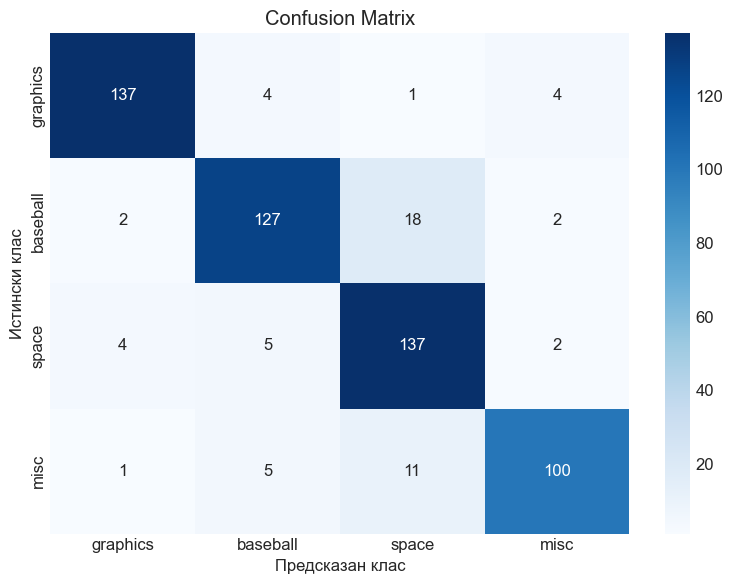

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[n.split('.')[-1] for n in label_names],
            yticklabels=[n.split('.')[-1] for n in label_names])
plt.xlabel('Предсказан клас')
plt.ylabel('Истински клас')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Диагоналът показва правилни класификации. Извън диагонала са грешките.

### Кога коя метрика?

| Ситуация | Метрика | Пример |
|----------|---------|--------|
| Скъпи False Positives | **Precision** | Spam в inbox |
| Скъпи False Negatives | **Recall** | Пропусната болест |
| Балансиран компромис | **F1-score** | Повечето случаи |

---
## 7. N-gram езикови модели

### Какво е езиков модел?

Езиковият модел присвоява **вероятност на поредица от думи**.

$$P(w_1, w_2, \ldots, w_n)$$

**Приложения:**
- Speech recognition: "recognize speech" vs "wreck a nice beach"
- Machine translation: избор на по-естествен превод
- Text generation: основа на всички LLM!

### Chain Rule на вероятностите

$$P(w_1, w_2, \ldots, w_n) = \prod_{i=1}^{n} P(w_i | w_1, \ldots, w_{i-1})$$

**Пример:**
$$P(\text{the cat sat}) = P(\text{the}) \cdot P(\text{cat}|\text{the}) \cdot P(\text{sat}|\text{the cat})$$

**Проблем:** Твърде много възможни истории! Не можем да оценим $P(w_i | w_1, \ldots, w_{i-1})$ за всички комбинации.

### Markov предположение (N-gram)

Гледаме само последните $n-1$ думи:

| Модел | Предположение |
|-------|---------------|
| Unigram | $P(w_i)$ — независими думи |
| Bigram | $P(w_i | w_{i-1})$ — зависи от предходната |
| Trigram | $P(w_i | w_{i-2}, w_{i-1})$ — от последните две |

### Оценка на вероятностите (MLE)

**Bigram:**
$$P(w_i | w_{i-1}) = \frac{C(w_{i-1}, w_i)}{C(w_{i-1})}$$

Където $C(\cdot)$ е брой появявания в корпуса.

In [17]:
# Помощни функции за n-gram модел
def tokenize(text):
    """Прост tokenizer: lowercase + split на думи"""
    text = text.lower()
    tokens = re.findall(r'\b[a-z]+\b', text)
    return ['<s>'] + tokens + ['</s>']

def get_ngrams(tokens, n):
    """Извлича n-грами от списък с токени"""
    return [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

# Тест
sample = "The cat sat on the mat."
tokens = tokenize(sample)
print(f"Текст: {sample}")
print(f"Токени: {tokens}")
print(f"Bigrams: {get_ngrams(tokens, 2)}")

Текст: The cat sat on the mat.
Токени: ['<s>', 'the', 'cat', 'sat', 'on', 'the', 'mat', '</s>']
Bigrams: [('<s>', 'the'), ('the', 'cat'), ('cat', 'sat'), ('sat', 'on'), ('on', 'the'), ('the', 'mat'), ('mat', '</s>')]


In [18]:
# Малък корпус за демонстрация
corpus = [
    "The cat sat on the mat.",
    "The dog sat on the rug.",
    "The cat ate the food.",
    "The dog ate the bone.",
    "A cat sat quietly.",
    "The mat was old."
]

print("Корпус:")
for s in corpus:
    print(f"  {s}")

Корпус:
  The cat sat on the mat.
  The dog sat on the rug.
  The cat ate the food.
  The dog ate the bone.
  A cat sat quietly.
  The mat was old.


In [19]:
class BigramLM:
    """Прост bigram езиков модел"""
    
    def __init__(self):
        self.bigram_counts = Counter()
        self.unigram_counts = Counter()
        self.vocab = set()
    
    def train(self, corpus):
        """Обучава модела на корпус от изречения"""
        for sentence in corpus:
            tokens = tokenize(sentence)
            self.vocab.update(tokens)
            
            for token in tokens:
                self.unigram_counts[token] += 1
            
            for bigram in get_ngrams(tokens, 2):
                self.bigram_counts[bigram] += 1
    
    def prob(self, word, context):
        """P(word | context) с add-1 smoothing"""
        bigram = (context, word)
        # Add-1 (Laplace) smoothing
        numerator = self.bigram_counts[bigram] + 1
        denominator = self.unigram_counts[context] + len(self.vocab)
        return numerator / denominator
    
    def sentence_prob(self, sentence):
        """Вероятност на изречение"""
        tokens = tokenize(sentence)
        prob = 1.0
        for i in range(1, len(tokens)):
            prob *= self.prob(tokens[i], tokens[i-1])
        return prob
    
    def perplexity(self, sentence):
        """Perplexity на изречение"""
        tokens = tokenize(sentence)
        N = len(tokens) - 1  # Без <s>
        log_prob = 0
        for i in range(1, len(tokens)):
            p = self.prob(tokens[i], tokens[i-1])
            log_prob += np.log2(p)
        return 2 ** (-log_prob / N)

In [20]:
# Обучаваме модела
lm = BigramLM()
lm.train(corpus)

print(f"Размер на речника: {len(lm.vocab)}")
print(f"Брой bigrams: {len(lm.bigram_counts)}")

Размер на речника: 16
Брой bigrams: 25


In [21]:
# Най-чести bigrams
print("Топ 10 bigrams:\n")
for bigram, count in lm.bigram_counts.most_common(10):
    print(f"  {bigram}: {count}")

Топ 10 bigrams:

  ('<s>', 'the'): 5
  ('the', 'cat'): 2
  ('cat', 'sat'): 2
  ('sat', 'on'): 2
  ('on', 'the'): 2
  ('the', 'mat'): 2
  ('the', 'dog'): 2
  ('ate', 'the'): 2
  ('mat', '</s>'): 1
  ('dog', 'sat'): 1


In [22]:
# Условни вероятности
print("P(word | 'the'):\n")
context = 'the'
candidates = ['cat', 'dog', 'mat', 'food', 'elephant']

for word in candidates:
    p = lm.prob(word, context)
    count = lm.bigram_counts[(context, word)]
    print(f"  P({word} | {context}) = {p:.3f}  [count: {count}]")

P(word | 'the'):

  P(cat | the) = 0.120  [count: 2]
  P(dog | the) = 0.120  [count: 2]
  P(mat | the) = 0.120  [count: 2]
  P(food | the) = 0.080  [count: 1]
  P(elephant | the) = 0.040  [count: 0]


"elephant" има нулев count, но получава ненулева вероятност заради smoothing.

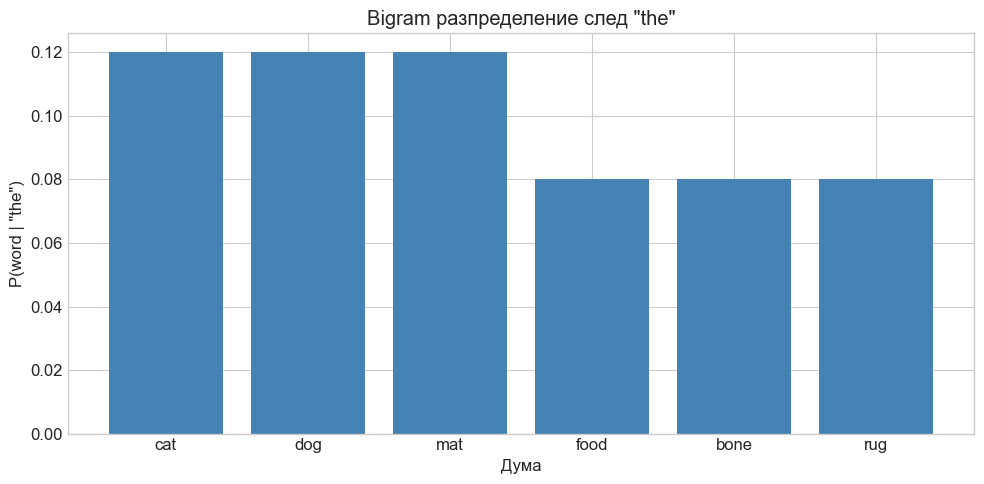

In [23]:
# Визуализация на разпределението
context = 'the'
words = ['cat', 'dog', 'mat', 'food', 'bone', 'rug']
probs = [lm.prob(w, context) for w in words]

plt.figure(figsize=(10, 5))
plt.bar(words, probs, color='steelblue')
plt.xlabel('Дума')
plt.ylabel('P(word | "the")')
plt.title(f'Bigram разпределение след "{context}"')
plt.tight_layout()
plt.show()

### Perplexity: Оценка на езикови модели

**Интуиция:** Колко "изненадан" е моделът от текста?

$$\text{Perplexity}(W) = P(w_1, \ldots, w_N)^{-1/N} = 2^{H(W)}$$

Където $H(W)$ е cross-entropy.

**Интерпретация:**
- По-ниска perplexity = по-добър модел
- Ако perplexity = 100, моделът е "изненадан" колкото при избор от 100 равновероятни думи

In [24]:
# Perplexity на различни изречения
test_sentences = [
    "The cat sat on the mat.",      # Подобно на train
    "The dog ate the bone.",         # В train
    "A cat sat quietly.",            # В train
    "The elephant flew away.",       # Нови думи
    "Cat the sat mat on.",           # Граматически грешно
]

print("Perplexity на тестови изречения:\n")
for sent in test_sentences:
    pp = lm.perplexity(sent)
    print(f"  PP={pp:6.1f}  '{sent}'")

Perplexity на тестови изречения:

  PP=   6.6  'The cat sat on the mat.'
  PP=   7.5  'The dog ate the bone.'
  PP=   8.6  'A cat sat quietly.'
  PP=  13.0  'The elephant flew away.'
  PP=  20.0  'Cat the sat mat on.'


По-ниска perplexity за изречения, подобни на тренировъчните.

In [25]:
# Генериране на текст
def generate(lm, max_words=10, seed=None):
    """Генерира текст от bigram модел"""
    if seed:
        np.random.seed(seed)
    
    tokens = ['<s>']
    
    for _ in range(max_words):
        context = tokens[-1]
        
        # Намираме възможни продължения
        candidates = []
        probs = []
        for word in lm.vocab:
            if word != '<s>':
                p = lm.prob(word, context)
                candidates.append(word)
                probs.append(p)
        
        # Нормализираме и избираме
        probs = np.array(probs) / sum(probs)
        next_word = np.random.choice(candidates, p=probs)
        
        if next_word == '</s>':
            break
        tokens.append(next_word)
    
    return ' '.join(tokens[1:])  # Без <s>

print("Генерирани изречения:\n")
for i in range(5):
    print(f"  {generate(lm, seed=i)}")

Генерирани изречения:

  the dog quietly food was was mat cat sat old
  the cat mat the a a was
  the mat bone
  
  on bone on quietly quietly rug on mat rug


### Ограничения на n-gram модели

| Проблем | Описание |
|---------|----------|
| **Sparsity** | Повечето n-грами имат нулев count |
| **Без генерализация** | "cat sat" и "dog sat" са напълно несвързани |
| **Къс контекст** | Bigram вижда само 1 дума назад |
| **Storage** | Трябва да пазим всички counts |

In [26]:
# Демонстрация на sparsity
vocab_size = len(lm.vocab)
possible_bigrams = vocab_size * vocab_size
actual_bigrams = len(lm.bigram_counts)

print(f"Размер на речника: {vocab_size}")
print(f"Възможни bigrams: {possible_bigrams}")
print(f"Наблюдавани bigrams: {actual_bigrams}")
print(f"Sparsity: {(1 - actual_bigrams/possible_bigrams)*100:.1f}%")

Размер на речника: 16
Възможни bigrams: 256
Наблюдавани bigrams: 25
Sparsity: 90.2%


Дори на малък корпус, повечето bigrams никога не се появяват. На реален корпус sparsity е > 99.9%.

In [27]:
# Проблем: Липса на генерализация
print("Липса на семантична генерализация:\n")
print(f"  P(sat | cat) = {lm.prob('sat', 'cat'):.3f}")
print(f"  P(sat | dog) = {lm.prob('sat', 'dog'):.3f}")
print(f"  P(sat | horse) = {lm.prob('sat', 'horse'):.3f}  (не е виждано)")
print("\nМоделът не знае, че 'cat', 'dog', 'horse' са сходни!")

Липса на семантична генерализация:

  P(sat | cat) = 0.158
  P(sat | dog) = 0.111
  P(sat | horse) = 0.062  (не е виждано)

Моделът не знае, че 'cat', 'dog', 'horse' са сходни!


**Мост към следващата лекция:**

Тези ограничения мотивират невронни подходи:
- Word embeddings: думи като вектори (сходни думи са близо)
- Neural language models: генерализация чрез споделени параметри
- Transformers: дълъг контекст чрез attention

---
## 8. NLP-специфични предизвикателства

### Проблеми, които ще решаваме

| Предизвикателство | Лекция |
|-------------------|--------|
| Представяне на думи като вектори | 2 (Embeddings) |
| Какво е "дума"? Tokenization | 3 |
| Обработка на поредици | 4 (RNN, LSTM) |
| Дълъг контекст | 5 (Transformers) |

In [28]:
# Out-of-Vocabulary (OOV) проблем
train_texts = ["Обичам машинно обучение", "ML е интересно"]
test_texts = ["Deep learning е страхотно"]

vec = CountVectorizer()
vec.fit(train_texts)

print("OOV проблем:\n")
print(f"Train речник: {list(vec.get_feature_names_out())}")
print(f"Test текст: '{test_texts[0]}'")
print(f"Test вектор: {vec.transform(test_texts).toarray()}")
print("\n'Deep' и 'learning' липсват в речника!")

OOV проблем:

Train речник: ['ml', 'интересно', 'машинно', 'обичам', 'обучение']
Test текст: 'Deep learning е страхотно'
Test вектор: [[0 0 0 0 0]]

'Deep' и 'learning' липсват в речника!


**Решение:** Subword tokenization (BPE, WordPiece) — Лекция 3.

---
## 9. Практически NLP Workflow

```
1. Дефинирай задачата
2. Събери и разгледай данните
3. Предобработка (preprocessing)
4. Извличане на признаци / Tokenization
5. Раздели данните (train/val/test)
6. Избери и обучи модел
7. Оцени на validation set
8. Tune hyperparameters
9. Финална оценка на test set
10. Error analysis
```

### Чести грешки в NLP

| Грешка | Описание |
|--------|----------|
| **Data leakage** | Fit vectorizer на test данни |
| **Test contamination** | Моделът е виждал test данни при pretraining |
| **Vocabulary mismatch** | Различни домейни за train/test |
| **Inconsistent preprocessing** | Различна обработка на train/test |

In [29]:
# Error analysis
errors = np.where(y_test != y_test_pred)[0]

print(f"Error Analysis: {len(errors)} грешки от {len(y_test)}\n")

for idx in errors[:3]:
    text = X_test[idx][:100] + "..." if len(X_test[idx]) > 100 else X_test[idx]
    true_l = label_names[y_test[idx]].split('.')[-1]
    pred_l = label_names[y_test_pred[idx]].split('.')[-1]
    
    print(f"True: {true_l}, Pred: {pred_l}")
    print(f"Text: {text}\n")

Error Analysis: 59 грешки от 560

True: baseball, Pred: space
Text: It's me again!

True: baseball, Pred: space
Text: 

True: misc, Pred: space
Text: 
	He's 1/2 liar, 1/2 cheat and 1/2 demagogue.



---
## 10. Обобщение и мост към Лекция 2

### Ключови изводи

1. **ML е учене от данни** — Task, Experience, Performance
2. **Текстът изисква специално представяне** — BoW губи информация
3. **Три парадигми** — с учител, без учител, с подсилване
4. **Генерализацията е ключова** — пренагаждане vs ъндърфитване
5. **Метриките зависят от задачата** — accuracy не е достатъчна
6. **N-gram модели** — просто, но с фундаментални ограничения

### Следваща лекция: Невронни мрежи за NLP

Ще отговорим на:
- Как да представим думи, така че сходни думи да са близки?
- Как невронните мрежи решават ограниченията на n-gram модели?
- Какво е Word2Vec?

**Защо е важно:**
Word embeddings са основата на съвременните LLM.

---
## Ресурси

### Статии
1. "A Few Useful Things to Know About Machine Learning" — Pedro Domingos (2012)
2. "Natural Language Processing (almost) from Scratch" — Collobert et al. (2011)

### Учебници
1. "Speech and Language Processing" — Jurafsky & Martin (3rd ed.) — Ch. 3, 4
2. "Introduction to Information Retrieval" — Manning et al. — Ch. 13
3. "Pattern Recognition and Machine Learning" — Bishop — Ch. 1

### Online
1. Stanford CS229 Lecture Notes
2. Stanford CS224N Lecture 1
3. Scikit-learn documentation

---
## Упражнения

### Упражнение 1: Spam класификатор
- Заредете SMS Spam Collection dataset
- Обучете класификатор (BoW + Logistic Regression)
- Оценете с precision, recall, F1
- Анализирайте грешките

### Упражнение 2: N-gram модел
- Разширете BigramLM до trigram модел
- Сравнете perplexity на bigram vs trigram
- Генерирайте текст от двата модела

### Упражнение 3: Сравнение на признаци
- Сравнете unigrams vs bigrams vs trigrams за класификация
- Начертайте learning curves за всеки
- Кой представя данните най-добре?

---
## Край на Лекция 1

**Въпроси?**

---

**Следваща лекция:** Невронни мрежи за NLP